https://pseudo-lab.github.io/Tutorial-Book-en/chapters/en/object-detection/Ch5-Faster-R-CNN.html as a guide.

In [1]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
import torch
import torch.utils.data
import shutil
import random

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA L4


In [3]:

annotation_path = '/content/drive/MyDrive/LEGOLAS split rewrite'
image_path = '/content/drive/MyDrive/total'

test_image_path = '/content/drive/MyDrive/test images'
test_annotation_path = '/content/drive/MyDrive/test annotations'

catch_empty_path = '/content/drive/MyDrive/zeroed'


In [4]:
#reset directories
for img in os.listdir(test_image_path):
  shutil.move(os.path.join(test_image_path, img), os.path.join(image_path, img))

for annot in os.listdir(test_annotation_path):
  shutil.move(os.path.join(test_annotation_path, annot), os.path.join(annotation_path, annot))

for empty in os.listdir(catch_empty_path):
  if empty.endswith('.xml'):
    shutil.move(os.path.join(catch_empty_path,empty) , os.path.join(annotation_path, empty))
  else:
    shutil.move(os.path.join(catch_empty_path,empty) , os.path.join(image_path, empty))

In [5]:
print(len(os.listdir(annotation_path)))
print(len(os.listdir(image_path)))
print(len(os.listdir(catch_empty_path)))

1728
1728
0


In [6]:
for i in os.listdir(annotation_path):
    with open(os.path.join(annotation_path, i)) as f:
        data = f.read()
    soup = BeautifulSoup(data, "html.parser")
    objects = soup.find_all("object")

    num_objs = len(objects)

    if num_objs < 1:
      # remove from annotations and images
      i_name = i.split('.')[0] + '.jpg'
      shutil.move(os.path.join(image_path, i_name), os.path.join(catch_empty_path, i_name))
      shutil.move(os.path.join(annotation_path, i), os.path.join(catch_empty_path, i))

In [7]:
random.seed(1234)

size_dataset = len(os.listdir(image_path))
size_test = int(size_dataset * 0.2)

idx = random.sample(range(size_dataset), size_test)

for img in np.array(sorted(os.listdir(image_path)))[idx]:
    shutil.move(os.path.join(image_path, img), os.path.join(test_image_path, img))

In [8]:
for annot in np.array(sorted(os.listdir(annotation_path)))[idx]:
    shutil.move(os.path.join(annotation_path, annot), os.path.join(test_annotation_path, annot))


In [9]:
print(len(os.listdir(annotation_path)))
print(len(os.listdir(image_path)))
print(len(os.listdir(test_annotation_path)))
print(len(os.listdir(test_image_path)))

1382
1382
345
345


In [10]:
def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):

    if obj.find('name').text == "Tray Well":

        return 1 + adjust_label

    return 0 + adjust_label

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [11]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join(test_annotation_path, file_label)
        else:
            label_path = os.path.join(annotation_path, file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [12]:
data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, image_path)
test_dataset = MaskDataset(data_transform, test_image_path)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=20, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, collate_fn=collate_fn)


In [13]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [14]:
model = get_model_instance_segmentation(3)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [15]:
torch.cuda.is_available()

True

In [42]:
num_epochs = 20
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [43]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 11.563961029052734, time : 149.85641741752625
epoch : 2, Loss : 10.648903846740723, time : 149.6054232120514
epoch : 3, Loss : 10.38216781616211, time : 149.5228395462036
epoch : 4, Loss : 9.85767650604248, time : 149.7147741317749
epoch : 5, Loss : 9.465963363647461, time : 149.6317207813263
epoch : 6, Loss : 9.199226379394531, time : 149.59368753433228
epoch : 7, Loss : 8.772610664367676, time : 149.69164061546326
epoch : 8, Loss : 8.654876708984375, time : 149.6143593788147
epoch : 9, Loss : 8.649017333984375, time : 149.5707972049713
epoch : 10, Loss : 8.523856163024902, time : 149.60217571258545
epoch : 11, Loss : 8.578598022460938, time : 149.56611561775208
epoch : 12, Loss : 8.594781875610352, time : 149.6590690612793
epoch : 13, Loss : 8.306453704833984, time : 149.6067681312561
epoch : 14, Loss : 8.034360885620117, time : 149.6492371559143
epoch : 15, Loss : 7.770890235900879, time : 149.689956188201

In [44]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')


In [45]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

In [46]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)):
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [47]:
with torch.no_grad():
    # batch size of the test set = 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break


[{'boxes': tensor([[681.2142, 509.5097, 936.0000, 777.0000],
        [656.7713, 233.5548, 936.0000, 519.3186],
        [374.9232,   0.0000, 649.7213, 246.2691],
        [391.4268, 253.2753, 641.2130, 512.3470],
        [133.6107, 557.6021, 405.9928, 777.0000],
        [104.5248, 272.7962, 357.1473, 533.3113],
        [ 74.0667,   0.0000, 345.4099, 246.7825],
        [642.3680,   0.0000, 918.3217, 235.9836],
        [420.7043, 534.7040, 673.9473, 777.0000]], device='cuda:0'), 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0'), 'scores': tensor([0.9981, 0.9978, 0.9970, 0.9966, 0.9940, 0.9927, 0.9916, 0.9900, 0.9842],
       device='cuda:0')}, {'boxes': tensor([[377.6789,   0.0000, 634.7836, 250.6954],
        [670.0387, 239.1905, 936.0000, 506.8806],
        [100.2337, 270.1297, 372.4698, 530.7571],
        [392.0695, 242.4885, 648.9903, 509.0482],
        [ 99.2069,   0.0000, 345.9936, 255.7265],
        [651.4004,   0.0000, 903.4987, 212.1936],
        [692.6564, 528.4042, 

In [48]:
annotations[0]['labels']

tensor([2, 2, 2, 2, 2, 2, 2, 2])

Target :  tensor([2, 2, 2, 2, 2, 2, 2, 2])


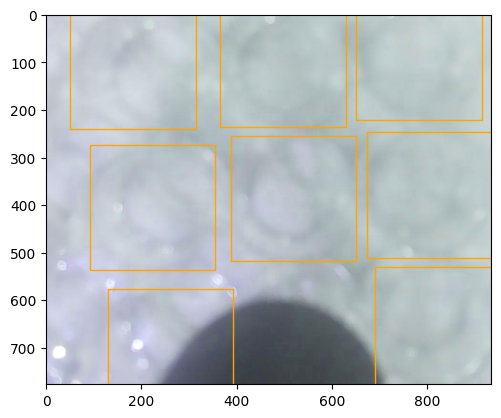

Prediction :  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [49]:
_idx = 0

print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
#plot_image_from_output(imgs[_idx], pred[_idx])

In [50]:
pred[0]

{'boxes': tensor([[681.2142, 509.5097, 936.0000, 777.0000],
         [656.7713, 233.5548, 936.0000, 519.3186],
         [374.9232,   0.0000, 649.7213, 246.2691],
         [391.4268, 253.2753, 641.2130, 512.3470],
         [133.6107, 557.6021, 405.9928, 777.0000],
         [104.5248, 272.7962, 357.1473, 533.3113],
         [ 74.0667,   0.0000, 345.4099, 246.7825],
         [642.3680,   0.0000, 918.3217, 235.9836],
         [420.7043, 534.7040, 673.9473, 777.0000]], device='cuda:0'),
 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0'),
 'scores': tensor([0.9981, 0.9978, 0.9970, 0.9966, 0.9940, 0.9927, 0.9916, 0.9900, 0.9842],
        device='cuda:0')}

In [51]:
annotations[0]

{'boxes': tensor([[ 50., -24., 314., 240.],
         [365., -29., 629., 235.],
         [652., -44., 916., 220.],
         [388., 254., 652., 518.],
         [ 91., 273., 355., 537.],
         [691., 530., 955., 794.],
         [129., 577., 393., 841.],
         [675., 246., 939., 510.]]),
 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2])}

In [52]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


In [53]:
# from https://github.com/Pseudo-Lab/Tutorial-Book-Utils

def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i] # predict
        # pred_boxes = output['boxes']
        # pred_scores = output['scores']
        # pred_labels = output['labels']

        true_positives = torch.zeros(output['boxes'].shape[0])   # 예측 객체 개수

        annotations = targets[sample_i]  # actual
        target_labels = annotations['labels'] if len(annotations) else []
        if len(annotations):    # len(annotations) = 3
            detected_boxes = []
            target_boxes = annotations['boxes']

            for pred_i, (pred_box, pred_label) in enumerate(zip(output['boxes'], output['labels'])): # 예측값에 대해서..

                # If targets are found break
                if len(detected_boxes) == len(target_labels): # annotations -> target_labels
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)   # box_index : 실제 어떤 바운딩 박스랑 IoU 가 가장 높은지 index
                if iou >= iou_threshold and box_index not in detected_boxes: # iou만 맞으면 통과?
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]  # 예측된거랑 실제랑 매핑해서 하나씩 index 채움
        batch_metrics.append([true_positives, output['scores'], output['labels']])
    return batch_metrics

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou
def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = torch.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = torch.unique(target_cls)   # 2가 거의 예측안됨

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in unique_classes:
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = torch.cumsum(1 - tp[i],-1)
            tpc = torch.cumsum(tp[i],-1)

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = torch.tensor(np.array(p)), torch.tensor(np.array(r)), torch.tensor(np.array(ap))
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


In [54]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.1638793342377361
AP : tensor([0.1639], dtype=torch.float64)


In [55]:
torch.mean(precision)

tensor(0.4110)